In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from scipy import signal
from datetime import datetime
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision.io import read_image

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

use_colab = True
if use_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    PROJ_DIRECTORY = '/content/gdrive/Shareddrives/CS523 Final Project/'
    DATA_DIRECTORY = os.path.join(PROJ_DIRECTORY, 'data/')
else:
    DATA_DIRECTORY = '/projectnb/dl523/?'

Random Seed:  999
Mounted at /content/gdrive


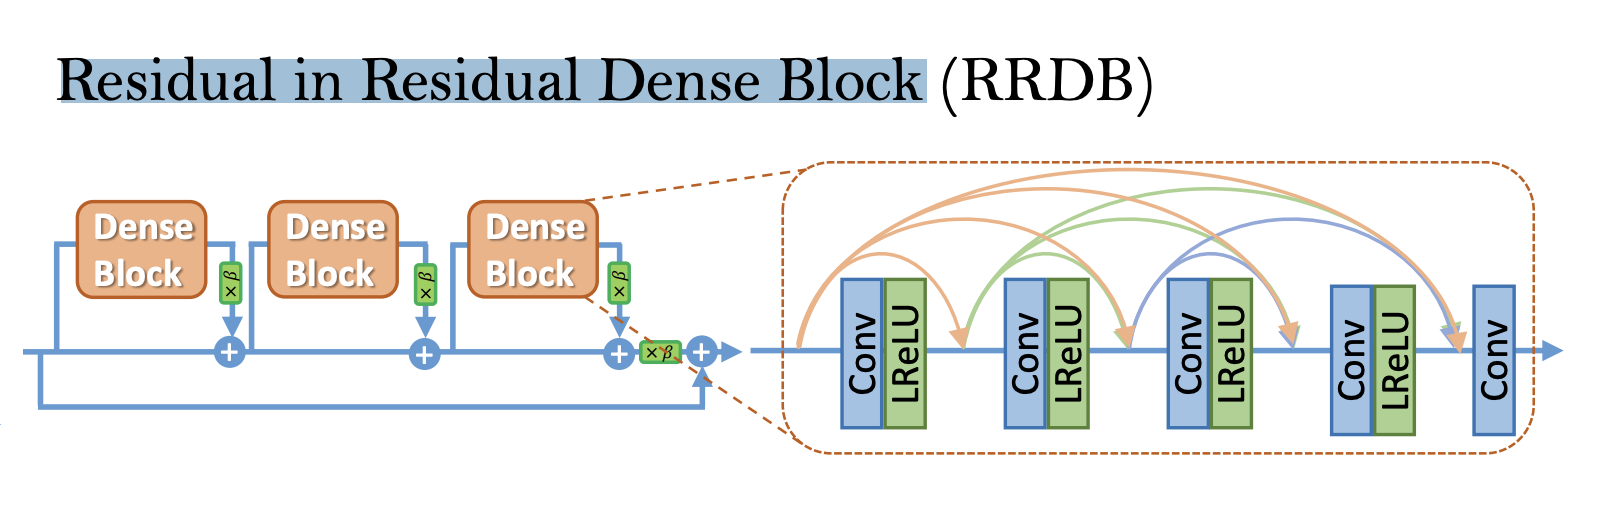

In [ ]:
class RDenseBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, channels: int, growths: int=8, n: int=5) -> None:
        super(RDenseBlock, self).__init__()
        self.n = n
        self.LRelu = nn.LeakyReLU(0.2, inplace=True)

        # Build n chanined dense blocks
        self.DB = nn.ModuleList()
        for g in range(self.n):
            if g < n - 1:
                self.DB.append(nn.Sequential(
                        nn.Conv2d(channels + g * growths, growths, kernel_size=3, stride=1, padding=1),
                        self.LRelu
                    ))
            else:
                self.DB.append(nn.Sequential(
                        nn.Conv2d(channels + g * growths, channels, kernel_size=3, stride=1, padding=1),
                    ))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Execute n chained dense blocks appending each output as the next input
        outs = [x]
        for g in range(self.n):
            DB = self.DB[g]
            out = DB(torch.cat(outs, 1))
            outs.append(out)

        return outs[-1]

In [ ]:
class Generator(nn.Module):
    """Generator network."""
    # n = number of repeated block in each RRDB module
    # B = number of RRDB block
    # beta = weight of the output from RRDBlock when adding to input pre-RRDBlock
    def __init__(self, upsample: int=4, conv_dim: int=64, beta: float=0.1, n: int=5, B: int=23):
        super(Generator, self).__init__()
        self.upsample = upsample
        self.conv_dim = conv_dim
        self.beta = beta
        self.n = n
        self.B = B

        self.unshuffle = nn.PixelUnshuffle(4 // upsample)
        self.shuffle = nn.PixelShuffle(2)

        # Convert to low-resolution, high-dimension space
        self.conv_first = nn.Conv2d(3 * ((4 // upsample) ** 2), conv_dim, kernel_size=3, stride=1, padding=1)
        self.LRelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # Residual in residual dense block built using RDenseBlock. ESRGAN paper uses 23 of these
        self.body = nn.ModuleList()
        for i in range(B):
            self.body.append(
                RDenseBlock(channels=conv_dim, growths=32, n=n)
            )
        self.conv_body = nn.Conv2d(conv_dim, conv_dim, kernel_size=3, stride=1, padding=1)

        # Upsampling layer which doubles the resolution of the image each time
        self.conv_up1 = nn.Conv2d(conv_dim, conv_dim, kernel_size=3, stride=1, padding=1)
        self.conv_up2 = nn.Conv2d(conv_dim, conv_dim, kernel_size=3, stride=1, padding=1)

        # Connecting convolution layer after upsampling
        self.conv_hr = nn.Conv2d(conv_dim, conv_dim, kernel_size=3, stride=1, padding=1)

        # Convert back to 3-channel image
        self.conv_last = nn.Conv2d(conv_dim, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.upsample < 4:
            out = self.unshuffle(x)
        else:
            out = x

        out = self.conv_first(out)
        out = self.LRelu(out)

        # Iterate over each dense block
        x = out
        for i in range(self.B):
            x = self.body[i](x) * self.beta + x
        out = x * self.beta + out

        # Post RRDB
        out = self.conv_body(out)
        # out = self.LRelu(out)

        # Upscale by some multiple of 2
        if self.upsample > 1:
            out = self.conv_up1(F.interpolate(out, scale_factor=2, mode="bilinear"))
            # out = self.conv_up1(self.shuffle(out))
            out = self.LRelu(out)

        if self.upsample > 2:
            out = self.conv_up2(F.interpolate(out, scale_factor=2, mode="bilinear"))
            # out = self.conv_up2(self.shuffle(out))
            out = self.LRelu(out)

        # Post upsample
        out = self.conv_hr(out)
        # out = self.LRelu(out)

        # Convert to 3-channel output
        out = self.conv_last(out)
        # out = self.LRelu(out)
        return out
    
    def load_weights(self, file: str) -> None:
        # Load weights from .pth file
        old_weights = torch.load(os.path.join(PROJ_DIRECTORY, file))['params_ema']

        # Name analogies from Real-ESRGAN to implementation
        replace = {
            'rdb1': 'DB',
            'rdb2': 'DB',
            'rdb3': 'DB',
            'conv1': '0.0',
            'conv2': '1.0',
            'conv3': '2.0',
            'conv4': '3.0',
            'conv5': '4.0',
        }

        # Convert old weight to new weights to match state_dict
        weights = {}
        for old_key in old_weights:
            new_key = old_key
        
            for k, r in replace.items():
                new_key = new_key.replace(k, r)
                
            weights[new_key] = old_weights[old_key]  
        self.load_state_dict(weights)

In [ ]:
G = Generator(4, beta=0.13)
G.load_weights('Generator/RealESRGAN_x4.pth')

torch.Size([1, 3, 112, 112])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([3, 448, 448])


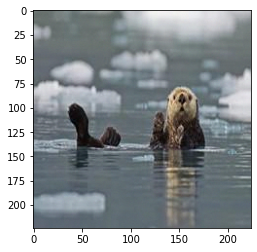

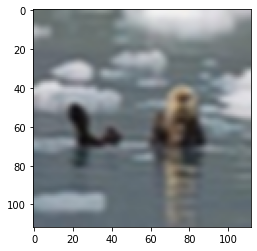

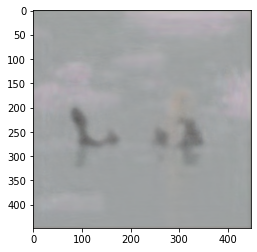

In [ ]:
transform = T.ToTensor()
to_pil = T.ToPILImage()
# import original image
img = Image.open(os.path.join(DATA_DIRECTORY, 'download.png'))
plt.figure()
plt.imshow(img)
# import degraded test image
img_deg = Image.open(os.path.join(DATA_DIRECTORY, 'download_deg.png'))
plt.figure()
plt.imshow(img_deg)
# Super Resolution via generator
img_tensor = transform(img_deg).unsqueeze(0)
print(img_tensor.size())
new_img = G(img_tensor).squeeze(0)
print(new_img.size())
new_img = to_pil(new_img)
plt.figure()
plt.imshow(new_img)